<a href="https://colab.research.google.com/github/Andarsan/client_contract/blob/main/github_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82_%D0%BA%D0%BE%D0%BD%D1%82%D1%80%D0%B0%D0%BA%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание проекта: телекоммуникации
* Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.


* Задача — **обучить на этих данных модель для прогноза оттока клиентов.**


# Описание услуг
Оператор предоставляет два основных типа услуг:
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).


Также доступны такие услуги:
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.


# Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv

* customerID — идентификатор абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.

Файл personal_new.csv

* customerID — идентификатор пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.

Файл internet_new.csv

* customerID — идентификатор пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.

Файл phone_new.csv

* customerID — идентификатор пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.
Данные также находятся в тренажёре, в папке /datasets/.


In [32]:
#Код ментора
# !pip install scikit-learn==1.4.0

## Загрузка данных

In [33]:
import pandas as pd
import requests
import io
import re
import matplotlib.pyplot as plt
import seaborn as sns
! pip install catboost
# Вычисление матрицы корреляции с использованием phik
! pip install phik
import phik
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix,precision_recall_curve, accuracy_score, roc_curve

from sklearn.model_selection import cross_val_score
! pip install shap
import shap

STATE = 170624

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [34]:
url_contract_new = 'https://raw.githubusercontent.com/Andarsan/client_contract/refs/heads/main/contract_new.csv'
url_personal_new = 'https://raw.githubusercontent.com/Andarsan/client_contract/refs/heads/main/personal_new.csv'
url_internet_new = 'https://raw.githubusercontent.com/Andarsan/client_contract/refs/heads/main/internet_new.csv'
url_phone_new = 'https://raw.githubusercontent.com/Andarsan/client_contract/refs/heads/main/phone_new.csv'

# Открытие файла с помощью pandas
df_contract = pd.read_csv(io.BytesIO(requests.get(url_contract_new).content))
df_personal = pd.read_csv(io.BytesIO(requests.get(url_personal_new).content))
df_internet = pd.read_csv(io.BytesIO(requests.get(url_internet_new).content))
df_phone = pd.read_csv(io.BytesIO(requests.get(url_phone_new).content))

In [35]:
#df_contract = pd.read_csv('C:/Users/andar/Downloads/contract_new.csv')
#df_personal = pd.read_csv('C:/Users/andar/Downloads/personal_new.csv')
##df_internet = pd.read_csv('C:/Users/andar/Downloads/internet_new.csv')
#df_phone = pd.read_csv('C:/Users/andar/Downloads/phone_new.csv')

In [36]:
def df_plt_describe(_df,_for,describe=False):
    plt.style.use('classic')
    plt.figure(figsize=(12,6))
    for i in _for:
        j=0
        for _ in range(1):
            if _df[i[0]].dtype != 'object':
                # Set up the plot
                ax = plt.subplot(2, 2, j + 1)
                j = j+1
                # Draw the plot

                ax.boxplot(_df[i[0]])
                plt.ylabel(i[2])
                plt.xlabel(f'медиана = {_df[i[0]].median():.2f}, среднее = {_df[i[0]].mean():.2f}')

                # Title and labels
                ax.set_title('Диаграмма размаха '+i[1])
                ax = plt.subplot(2, 2, j + 1)
                j = j+1
                # Draw the plot
                ax.hist(_df[i[0]], bins = 100)
                plt.label=i[2]
                plt.ylabel(i[3])
                plt.xlabel(i[2])
                #[['real_age','числа заказов','возраст','количество','возраст']]
                # Title and labels
                ax.set_title('Гистограмма ' + i[1])
        plt.tight_layout()
        plt.show()
        plt.close()
    if describe:
        display(_df[_for[0][0]].describe())
def pct(values):
        plt.style.use('ggplot')
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.2f}%'.format(pct, v=val)
        return my_format

## Исследовательский анализ и предобработка данных

### `contract_new.csv`

In [37]:
display(df_contract.head(5))
df_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


* пропусков нет это хорошо -)

* для начала переименуем признаки

In [38]:
df_contract = df_contract.rename(columns={'customerID':'customer_id'})
df_contract.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() \
                       for i in df_contract.columns]
df_contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [39]:
display(f'Количество уникальных пользователей customer_id: \
{len(df_contract.customer_id.unique())} из {df_contract.customer_id.count()}')

'Количество уникальных пользователей customer_id: 7043 из 7043'

* все пользователи уникальны здорво!

In [40]:
for i in ['begin_date','end_date']:
    display(f'Поле {i}')

    _i = pd.to_datetime(df_contract.begin_date, format='%Y-%m-%d', errors='coerce').\
    notnull().sum()

    display(f'Количество правельного формата даты : {_i} из \
    {df_contract.begin_date.count()}')

    display(f'Минимальная дата                    : {df_contract[i].min()}')
    display(f'Максимальная дата                   : {df_contract[i].max()}')

'Поле begin_date'

'Количество правельного формата даты : 7043 из     7043'

'Минимальная дата                    : 2013-10-01'

'Максимальная дата                   : 2020-02-01'

'Поле end_date'

'Количество правельного формата даты : 7043 из     7043'

'Минимальная дата                    : 2014-06-01'

'Максимальная дата                   : No'

* формат дат верный ура!
* `EndDate` целевой признак перевндём его в признак `active` 1 (контракт разорван) и 0 (контракт действует)

In [41]:
df_contract['active'] = 1
df_contract.loc[df_contract['end_date'] == 'No','active'] = 0
df_contract['active'].value_counts()

active
0    5942
1    1101
Name: count, dtype: int64

* внизу создадим признак `days_period = begin_date - end_date` модель будет знать сколько длился контракт
* сами даты не нужны **хотя можно попробывать добавить признак времена года или дни нидели**

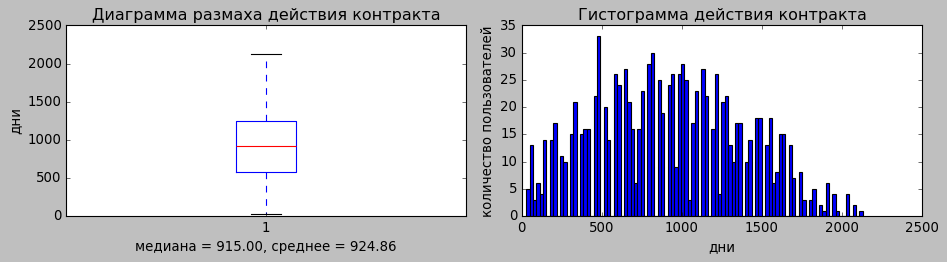

count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: days_period, dtype: float64

In [42]:
df_contract.loc[df_contract['end_date'] == 'No', 'end_date'] = \
df_contract['begin_date'].max()

df_contract['end_date'] = pd.to_datetime(df_contract['end_date'],format='%Y-%m-%d')
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'],format='%Y-%m-%d')

df_contract['days_period'] = (df_contract['end_date'] - df_contract['begin_date']).\
dt.components.days

# построим график только действующих контрактов
df_plt_describe(df_contract.query('active == 1'),
                [['days_period','действия контракта','дни','количество пользователей']],\
                True)

* Теперь признаки BeginDate и EndDate нужно удалить из модели. Во первых EndDate, это по сути второй целевой признак а во вторых не будем привязывать модель к временному промежутку

In [43]:
df_contract = df_contract.drop(['begin_date', 'end_date'], axis=1)

In [44]:
df_contract.type.value_counts()

type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

C:\Users\andar\AppData\Local\Temp\ipykernel_27848\2778258236.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = [df_contract.type.value_counts()[0],
C:\Users\andar\AppData\Local\Temp\ipykernel_27848\2778258236.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_contract.type.value_counts()[1],
C:\Users\andar\AppData\Local\Temp\ipykernel_27848\2778258236.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_contract.type.val

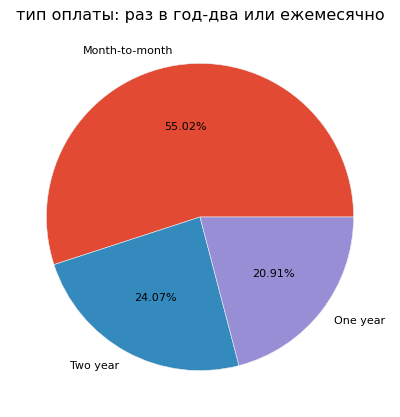

In [45]:
s = [df_contract.type.value_counts()[0],
     df_contract.type.value_counts()[1],
     df_contract.type.value_counts()[2]]

plt.pie(s,labels = [df_contract.type.value_counts().index[0],
                    df_contract.type.value_counts().index[1],
                    df_contract.type.value_counts().index[2]], autopct=pct(s))

plt.title('тип оплаты: раз в год-два или ежемесячно')
plt.show()

* данный признак категориальный учтём это

In [46]:
df_contract.paperless_billing.value_counts()

paperless_billing
Yes    4171
No     2872
Name: count, dtype: int64

In [47]:
df_contract.payment_method.value_counts()

payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

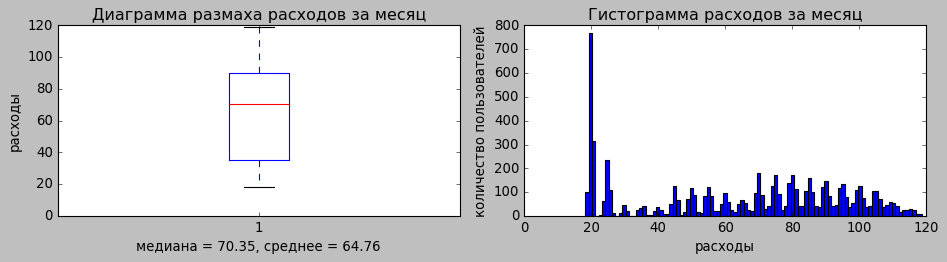

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

In [48]:
df_plt_describe(df_contract,[['monthly_charges','расходов за месяц','расходы','количество пользователей']],True)

* ступеньки похоже тарифы значит точно всё в порядке с данным признаком

In [49]:
# выесним что за строки вместо цифр
_i = []
for i in df_contract.total_charges:
    try:
        float(i)
    except:
        _i.append(i)
display(_i)



[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

* поменяем их на 0

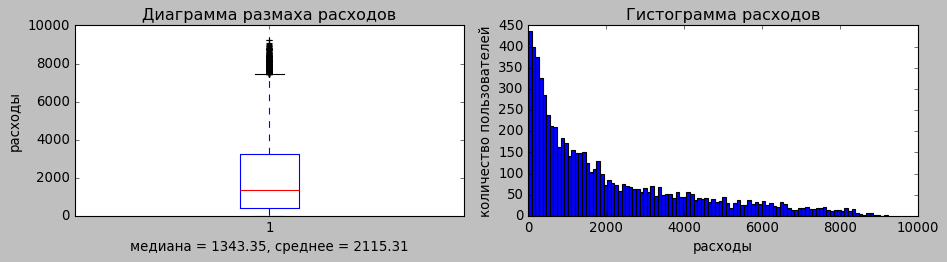

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: total_charges, dtype: float64

In [50]:
df_contract.total_charges = df_contract.total_charges.replace(' ',0)
df_contract.total_charges = df_contract.total_charges.astype('float64')

df_plt_describe(df_contract,[['total_charges','расходов','расходы','количество пользователей']],
                True)

* пришлось повозиться чтоб превратить данный признак в `float64`
* надо ркомендовать разрабодчикам исправить это

### `personal_new.csv`

In [51]:
display(df_personal.head(5))
df_personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [52]:
df_personal = df_personal.rename(columns={'customerID':'customer_id'})
df_personal.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() \
                       for i in df_personal.columns]
df_personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [53]:
display(f'Количество уникальных пользователей df_personal: \
{len(df_personal.customer_id.unique())} из {df_personal.customer_id.count()}')

'Количество уникальных пользователей df_personal: 7043 из 7043'

In [54]:
df_personal.gender.value_counts()

gender
Male      3555
Female    3488
Name: count, dtype: int64

In [55]:
df_personal.senior_citizen.value_counts()

senior_citizen
0    5901
1    1142
Name: count, dtype: int64

* признак категории избавимся от цифр

In [56]:
df_personal.senior_citizen = df_personal.senior_citizen.astype('object')
df_personal.loc[df_personal['senior_citizen'] == 1, 'senior_citizen'] = 'Yes'
df_personal.loc[df_personal['senior_citizen'] == 0, 'senior_citizen'] = 'No'

In [57]:
df_personal.partner.value_counts()

partner
No     3641
Yes    3402
Name: count, dtype: int64

In [58]:
df_personal.dependents.value_counts()

dependents
No     4933
Yes    2110
Name: count, dtype: int64

### `internet_new.csv`

In [59]:
display(df_internet.head(5))
df_internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [60]:
df_internet = df_internet.rename(columns={'StreamingTV':'streaming_tv'})
df_internet = df_internet.rename(columns={'customerID':'customer_id'})
df_internet.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() \
                       for i in df_internet.columns]
df_internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

In [61]:
df_internet.customer_id.unique()

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

In [62]:
display(f'Количество уникальных пользователей df_internet: \
{len(df_internet.customer_id.unique())} из {df_internet.customer_id.count()}')

'Количество уникальных пользователей df_internet: 5517 из 5517'

In [63]:
for i in ['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']:
    display(f'--------------{i}---------------')
    display(df_internet[i].value_counts())

'--------------internet_service---------------'

internet_service
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

'--------------online_security---------------'

online_security
No     3498
Yes    2019
Name: count, dtype: int64

'--------------online_backup---------------'

online_backup
No     3088
Yes    2429
Name: count, dtype: int64

'--------------device_protection---------------'

device_protection
No     3095
Yes    2422
Name: count, dtype: int64

'--------------tech_support---------------'

tech_support
No     3473
Yes    2044
Name: count, dtype: int64

'--------------streaming_tv---------------'

streaming_tv
No     2810
Yes    2707
Name: count, dtype: int64

'--------------streaming_movies---------------'

streaming_movies
No     2785
Yes    2732
Name: count, dtype: int64

### `phone_new.csv`

In [64]:
display(df_phone.head(5))
df_phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [65]:
df_phone = df_phone.rename(columns={'customerID':'customer_id'})
df_phone.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() \
                       for i in df_phone.columns]
df_phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

In [66]:
display(f'Количество уникальных пользователей df_phone: \
{len(df_phone.customer_id.unique())} из {df_phone.customer_id.count()}')

'Количество уникальных пользователей df_phone: 6361 из 6361'

C:\Users\andar\AppData\Local\Temp\ipykernel_27848\111597886.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = [df_phone.multiple_lines.value_counts()[0],
C:\Users\andar\AppData\Local\Temp\ipykernel_27848\111597886.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_phone.multiple_lines.value_counts()[1]]


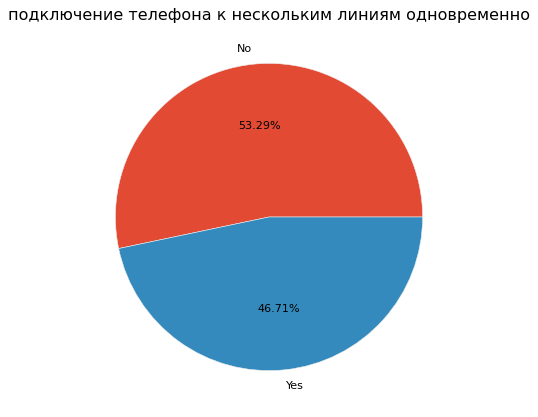

In [67]:
s = [df_phone.multiple_lines.value_counts()[0],
     df_phone.multiple_lines.value_counts()[1]]

plt.pie(s,labels = [df_phone.multiple_lines.value_counts().index[0],
                    df_phone.multiple_lines.value_counts().index[1]], autopct=pct(s))

plt.title('подключение телефона к нескольким линиям одновременно')
plt.show()

### **Итог анализа и обработки:**
* первым делом во всех 4х загруженных таблицах перевели название всех признаков к змеиному стилю.
* все представленные таблицы имеют признак customerID, это идентификатор клиента во всех таблицах он не имеет пропусков и дубликатов, что предварительно внушает доверия к целостности структуры данных (но это проверим при объединении всех таблиц).
* всего у нас 7043 клиента по ним есть полная информация без пропусков в двух таблицах, contract_new и personal_new,
* что касается двух других таблиц internet_new всего 5517 уникальных записей и phone_new 6361 уникальных записи, это говорит о том что не все клиенты пользуются данными услугами. При дальнейшим объединении в этих данных признаках выставим internet_off и phone_off.


* **Теперь пройдёмся по таблицам подробно:**


* **Internet_new** – содержит две даты BeginDate и EndDate это начало и конец контракта, следовательно если нет EndDate клиент активен, это позволило нам создать целевой признак active 1 (контракт разорван) и 0 (контракт действует). Также на основании разнице двух дат создали признак days_period (срок действия контракта в днях). Признак EndDate содержащий значения No был изменён на максимальную дату из признака BeginDate (эта 01.02.2020).
 * признаки BeginDate и EndDate удалили.
 * признаки  PaperlessBilling, PaymentMethod  и Type категориальные.
 * признаки MonthlyCharges и TotalCharges должны содержать числовые значения. Однако  признак TotalCharges имел тип object и что ещё хуже пробелы (11 записей). Данные были преобразованы в тип float64, пробелы заменил на 0 (предположим, что пробел это 0 мани)


* **personal_new** – содержит категориальные данные.
 * один признак SeniorCitizen пришлось обработать, он содержал 0 и 1, поменяли на No и Yes соответственно.


* **internet_new** – содержит категориальные данные.
 * предобработка не потребовалась все значения содержат бинарные данные.


* **phone_new** – содержит один бинарный признак No и Yes, предобработка не потребовалась.


## Объединение данных

* объединим по уникальному признаку `customer_id`

In [68]:
df_c_p = pd.concat([df_contract.set_index('customer_id'), df_personal.set_index('customer_id')],
                   axis=1)

df_c_p_i = pd.concat([df_c_p, df_internet.set_index('customer_id')], axis=1)
df_all = pd.concat([df_c_p_i, df_phone.set_index('customer_id')], axis=1)
display(df_all.head(5))
df_all.info()

,type,paperless_billing,payment_method,monthly_charges,total_charges,active,days_period,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   active             7043 non-null   int64  
 6   days_period        7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

* как и запланировали в пропусках выставим зачение `internet_off` и `phone_off`.

In [69]:


df_all['multiple_lines'] = df_all['multiple_lines'].fillna('multipleLines_off')

df_all[['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']] = \
df_all[['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies']].fillna('internet_off')

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   active             7043 non-null   int64  
 6   days_period        7043 non-null   int64  
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   object 
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   7043 non-null   object 
 12  online_security    7043 non-null   object 
 13  online_backup      7043 non-null   object 
 14  device_protection  7043 non-null   object 
 15  tech_support       7043 non-null   object 
 16  streaming_tv  

### **Итог:**
* все таблицы были объединены по уникальному признаку `customer_id` корректно, потерь и дубликатов нет.
* в пропусках по таблице `internet_new` вставили значение `internet_off`
* в пропусках по таблице `pone_new` вставили значение `pone _off`


* Всего получили 7043 строки и 21 колонку.


## Исследовательский анализ и предобработка данных объединённого датафрейма

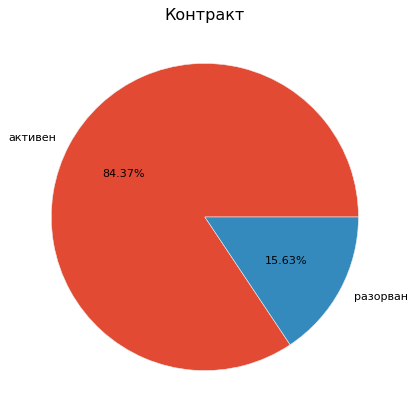

In [70]:
s = [df_all.active.value_counts()[0],
     df_all.active.value_counts()[1]]

plt.pie(s,labels = ['активен','разорван'], autopct=pct(s))
plt.title('Контракт')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


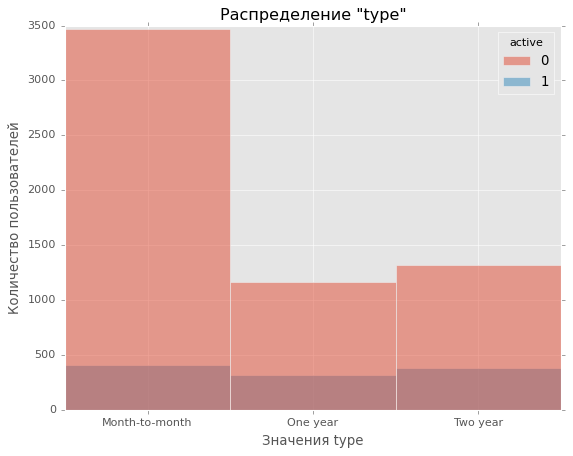

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


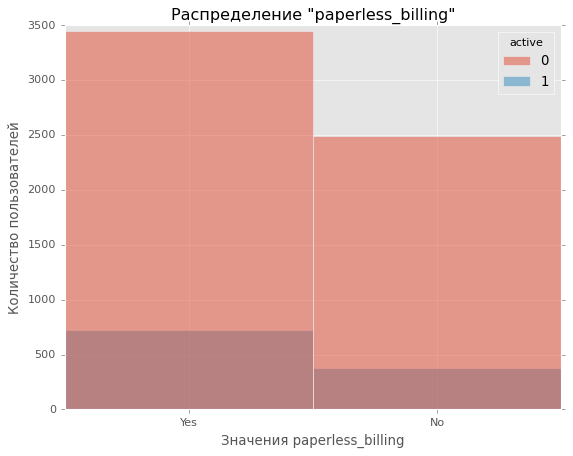

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


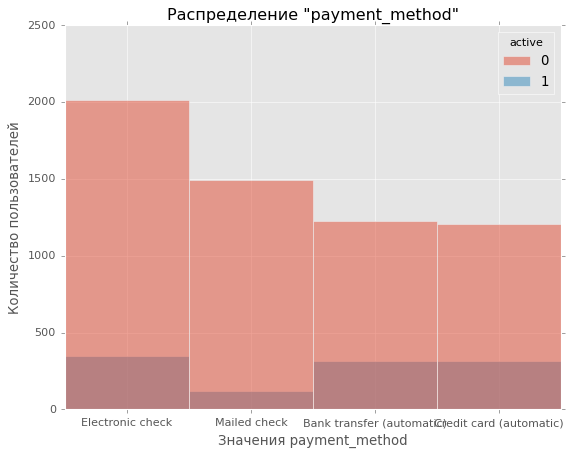

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


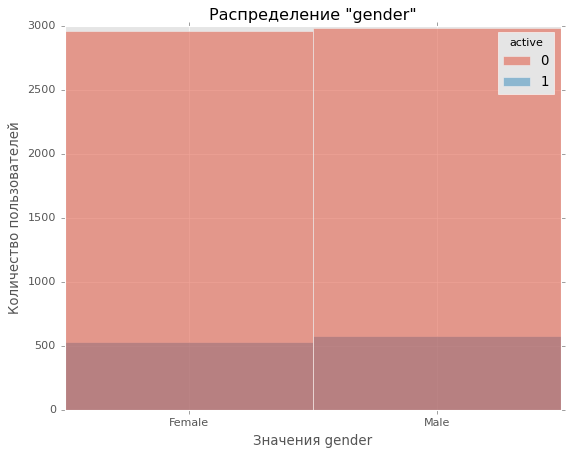

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


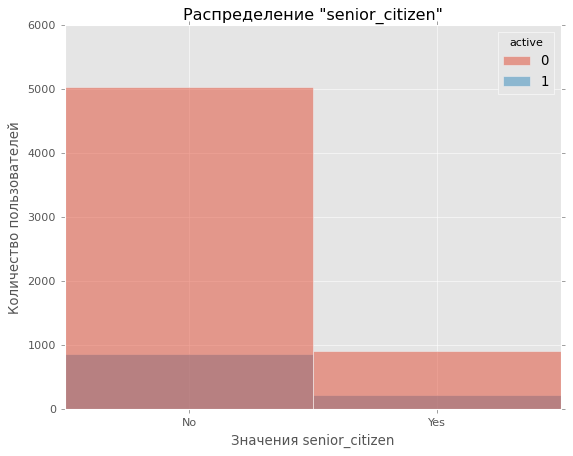

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


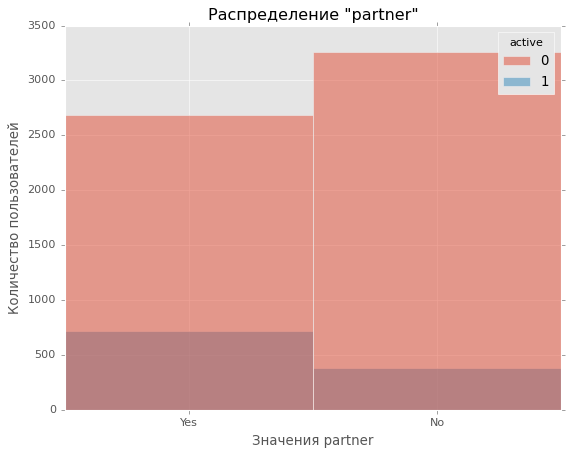

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


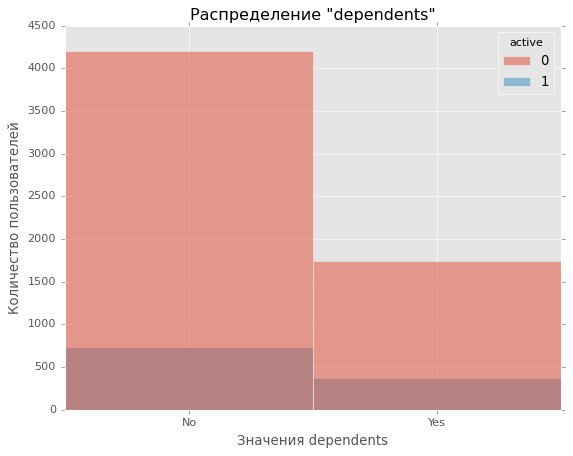

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


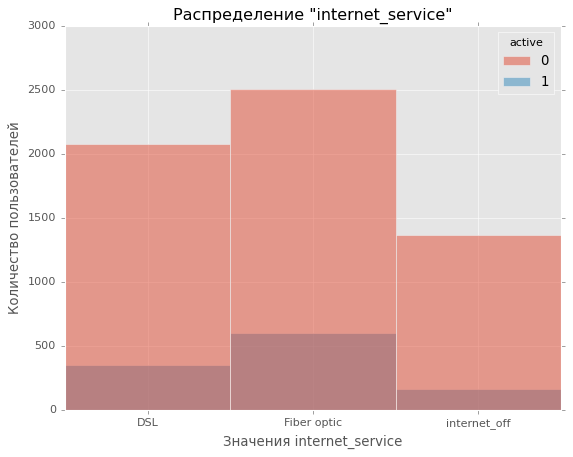

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


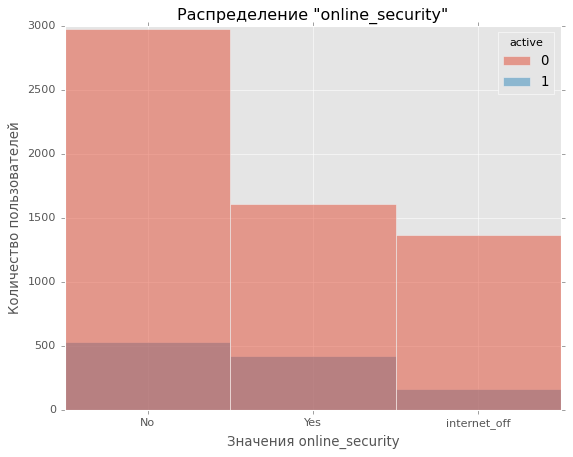

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


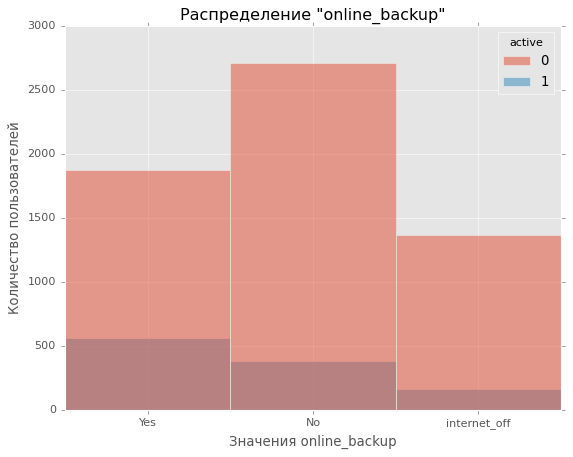

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


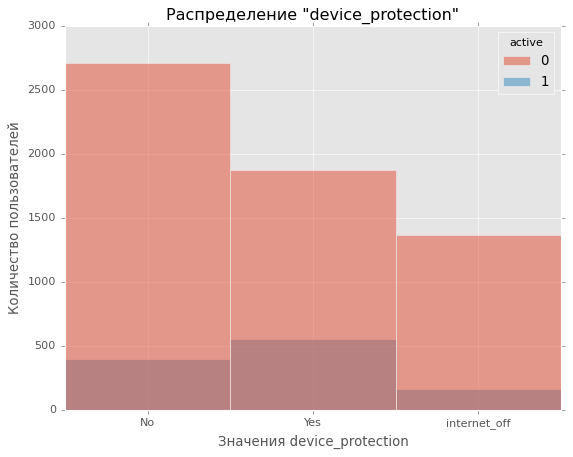

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


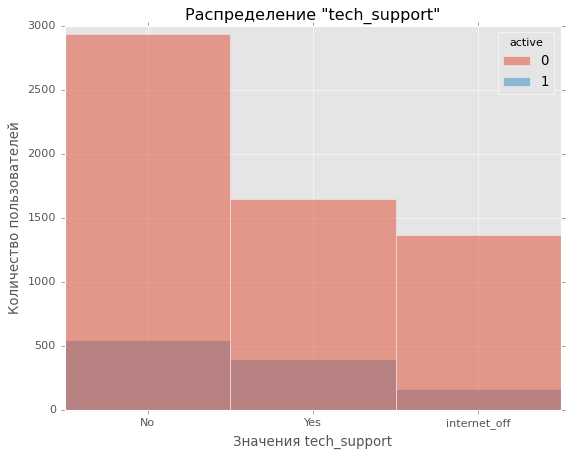

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


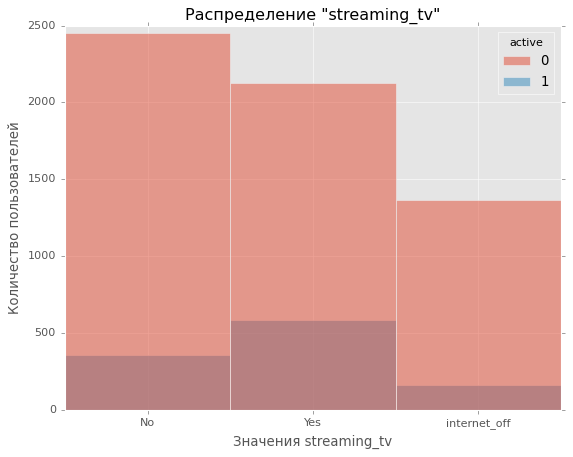

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


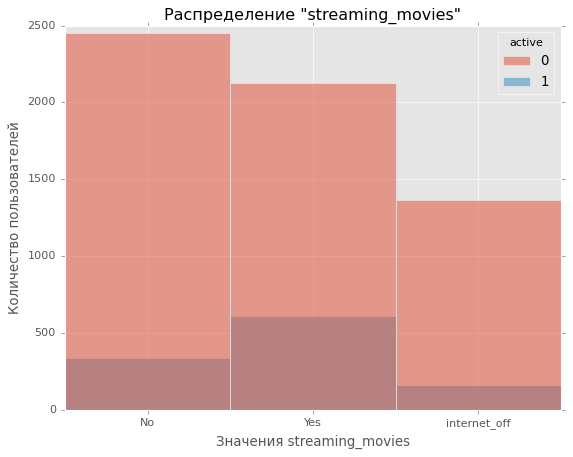

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


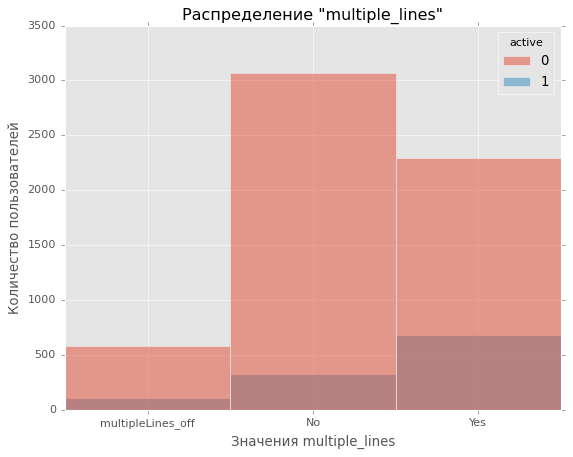

In [71]:
def df_all_histplot(df,x):
    sns.histplot(data=df_all, x = x, binwidth = 1, hue='active')
    plt.title(f'Распределение "{x}"')
    plt.xlabel(f'Значения {x}')
    plt.ylabel('Количество пользователей')
    plt.show()
for i in ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines']:
    df_all_histplot(df_all,i)

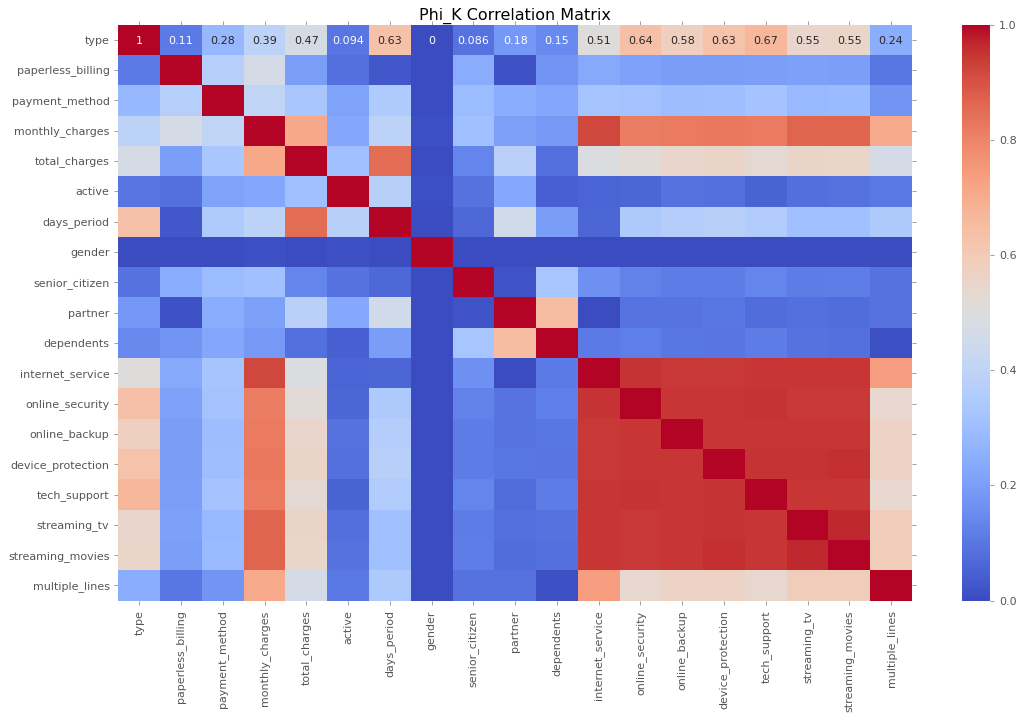

In [72]:
corr_matrix = df_all.phik_matrix(interval_cols = \
                                         [ 'monthly_charges', \
                                           'total_charges','days_period'])
# Визуализация матрицы корреляции
plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

In [73]:
corr_matrix['active'].sort_values()

gender               0.008581
dependents           0.046871
tech_support         0.051537
internet_service     0.056621
online_security      0.058659
streaming_tv         0.078545
paperless_billing    0.083398
device_protection    0.085608
senior_citizen       0.086159
streaming_movies     0.086577
online_backup        0.089704
type                 0.094015
multiple_lines       0.105101
payment_method       0.214832
monthly_charges      0.225925
partner              0.226688
total_charges        0.302890
days_period          0.374569
active               1.000000
Name: active, dtype: float64

### **Вывод:**
* имеем целевой признак active со значением  0 (контракт активен) и 1 (контракт разорван) в отношении 3 / 17 присутствующий дисбаланс это особенность данных ведь со временем накопления данных он будет меняться.
* все категориальные признаки внутри каждого класса сбалансированы в таком же соотношении это очень хорошо.
* очень высоких корреляций не видно, вывод мультиколлинеарности нет
* хорошая сбалансированная корреляция по числовым признакам `['monthly_charges', 'total_charges', 'days_period']`
* категориальные тоже сбалансированы хотя их корреляция невысокая
* можно убрать из модели признак `gender` у него совсем низкая корреляция


## Подготовка данных

In [74]:
categ_colum = ['dependents', 'tech_support', 'internet_service',
       'online_security', 'streaming_tv', 'paperless_billing',
       'device_protection', 'senior_citizen', 'streaming_movies',
       'online_backup', 'type', 'multiple_lines', 'payment_method', 'partner']

numeric_colum = ['monthly_charges', 'total_charges', 'days_period']

In [75]:
features = df_all.drop(['active','gender'], axis=1)
target = df_all['active']

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=.25,
    random_state=STATE
)

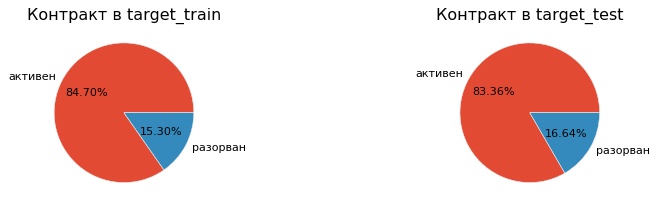

In [76]:
plt.figure(figsize=(12,6))
ax = plt.subplot(2, 2,  1)
s = [target_train.value_counts()[0],
     target_train.value_counts()[1]]
plt.pie(s,labels = ['активен','разорван'], autopct=pct(s))
plt.title('Контракт в target_train')
ax = plt.subplot(2, 2, 2)
s = [target_test.value_counts()[0],
     target_test.value_counts()[1]]
plt.pie(s,labels = ['активен','разорван'], autopct=pct(s))
plt.title('Контракт в target_test')
plt.show()


In [77]:
transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numeric_colum),
#                             ('ohe', OneHotEncoder(sparse=False, drop='first'), categ_colum)],
                            ('ohe', OneHotEncoder(sparse_output=False, drop='first'), categ_colum)],#Код ментора
                                remainder="passthrough"
                                  )

transformer.fit(features_train)
features_train = transformer.transform(features_train)
features_test = transformer.transform(features_test)

In [78]:
display('The scikit-learn version is {}.'.format(sklearn.__version__))

'The scikit-learn version is 1.2.2.'

### **Итог:**
* бъединенный датафрейм разделили на обучающую и тренировочную выборки, а также на целевой и не целевые признаки в отношении ¼.
* баланс по классу в обеих выборках сохранился практически одинаковый
* был исключён признак `gender`
* определились с категориальными и номерными признаками.
* категориальные кодировал `OneHotEncoder` а номерные стандартизировал `StandardScaler`

## Обучение моделей машинного обучения

### RandomForestClassifier

In [79]:
grid_params = {
    'n_estimators': [88,99],
    'max_depth' : [8,9]
}

grid_rfс = GridSearchCV(RandomForestClassifier(),
                        grid_params, cv=5,
                        scoring='roc_auc').fit(features_train, target_train)


auc_roc = grid_rfс.cv_results_['mean_test_score'].max()
print('AUC-ROC при лучших параметрах :', round(auc_roc, 3))
display(f'Параметры модели           :{grid_rfс.best_params_}')

AUC-ROC при лучших параметрах : 0.824


"Параметры модели           :{'max_depth': 8, 'n_estimators': 99}"

### CatBoostClassifier

In [80]:
model_catboost = CatBoostClassifier(logging_level='Silent', loss_function='Logloss')
parameters_catboost = {'max_depth': [4,6],
                  'learning_rate':[0.1],
                  'iterations': [2300]}

catboost_grid = GridSearchCV(model_catboost,
                             parameters_catboost,
                             cv=5,
                             scoring='roc_auc').fit(features_train, target_train)

auc_roc = catboost_grid.cv_results_['mean_test_score'].max()
print('AUC-ROC при лучших параметрах :', round(auc_roc, 3))
display(f'Параметры модели           :{catboost_grid.best_params_}')

AUC-ROC при лучших параметрах : 0.92


"Параметры модели           :{'iterations': 2300, 'learning_rate': 0.1, 'max_depth': 4}"

### **Итог:**


* модель CatBoostClassifier по результату тестирования методом кросс валидации на тестовой выборке показывает наилучший результат. Далее протестируем именно эту модель


## Выбор лучшей модели

In [81]:
test_cv = cross_val_score(catboost_grid.best_estimator_,
                          features_test,
                          target_test,
                          cv=5,
                          scoring = 'roc_auc').mean()

display(f'ROC_AUC на кросс-валидации :{test_cv}')

'ROC_AUC на кросс-валидации :0.8346334632575811'

In [82]:
y_pred_proba = catboost_grid.best_estimator_.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, y_pred_proba)
print('AUC-ROC на тестовом наборе данных:', round(auc_roc, 3))

AUC-ROC на тестовом наборе данных: 0.927


In [83]:
explainer = shap.Explainer(catboost_grid.best_estimator_, features_train)

feature_names_categorical = transformer.named_transformers_['ohe'].\
get_feature_names_out(categ_colum)

# feature_names_categorical = transformer.named_transformers_['ohe'].\
# get_feature_names_out(categ_colum) #Код ментора
feature_names = numeric_colum + list(feature_names_categorical)
shap_values=explainer(pd.DataFrame(features_train,columns=feature_names))

100%|===================| 5277/5282 [01:46<00:00]       

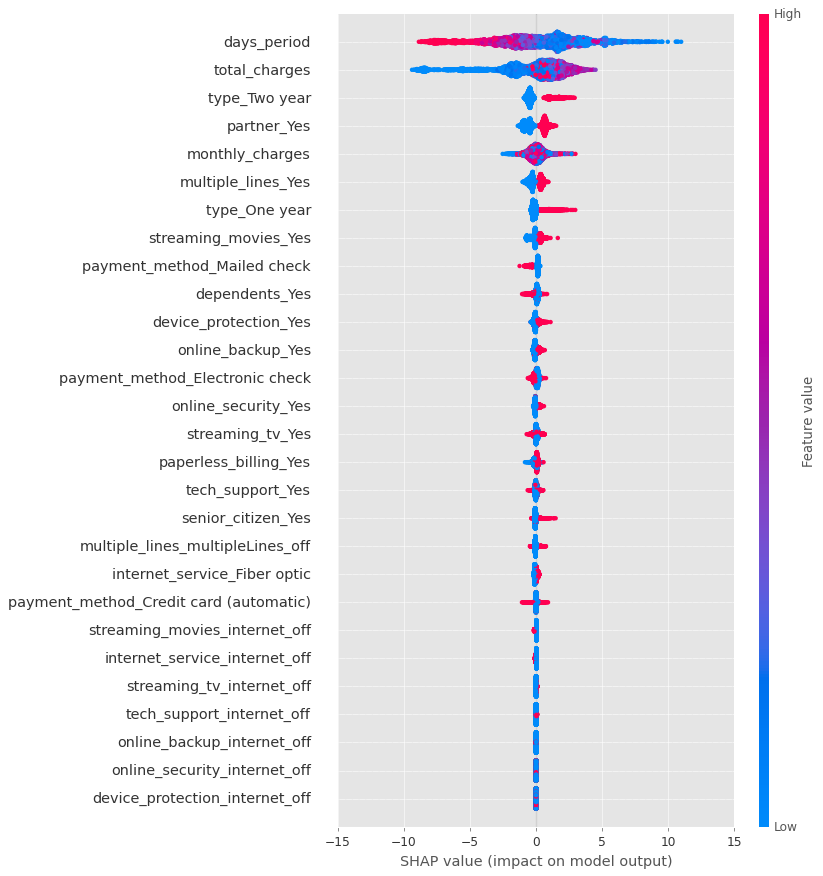

In [84]:
shap.plots.beeswarm(shap_values,max_display=29)

In [85]:
_importances = catboost_grid.best_estimator_.feature_importances_

_df = pd.DataFrame({'Признаки': feature_names,'Важность': _importances}) \
                    .sort_values('Важность', ascending = False)
display(_df)

,Признаки,Важность
2,days_period,47.133643
1,total_charges,14.103324
0,monthly_charges,12.870775
21,type_Two year,3.305135
27,partner_Yes,3.183295
20,type_One year,2.572581
22,multiple_lines_Yes,1.806423
18,online_backup_Yes,1.403430
13,device_protection_Yes,1.331260
3,dependents_Yes,1.321062


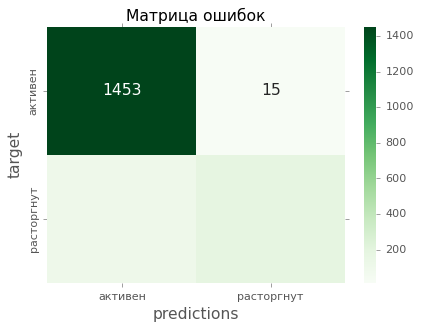

In [86]:
predictions = catboost_grid.best_estimator_.predict(features_test)
matrix_error = confusion_matrix(target_test, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix_error,
            xticklabels=['активен', 'расторгнут'],
            yticklabels=['активен', 'расторгнут'],
            annot=True,
            fmt='g',
            cmap="Greens",
            annot_kws={"size": 14})
plt.title('Матрица ошибок', size=14)
plt.xlabel('predictions', size=14)
plt.ylabel('target', size=14);

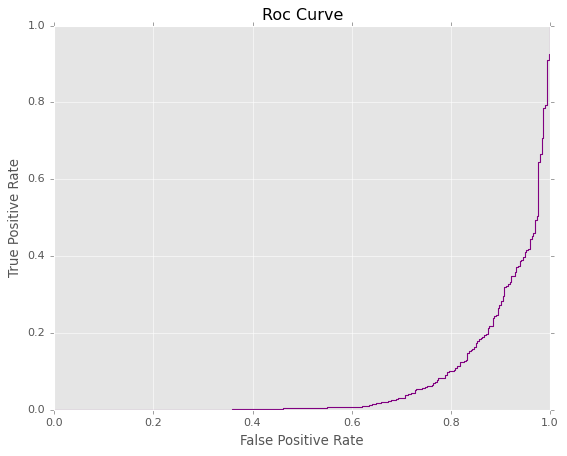

In [87]:
fpr, tpr, thresholds = roc_curve(target_test, y_pred_proba)
fig, ax = plt.subplots()
ax.plot(tpr, fpr, color='purple')
ax.set_title('Roc Curve')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

In [88]:
acc = accuracy_score(target_test, predictions)
display(f'Показатель метрики Accuracy : {acc}')

'Показатель метрики Accuracy : 0.9307211811470755'

### **Вывод:**


* в результате выбранной модели и подбора гиперпараметров получаем метрику ROC-AUC ~ 0.93


* по результату анализа важности признаков видно, что новый сгенерированный признак deys_period имеет наибольшее влияния на модель. Далее следует признаки monthly_charges и monthly_charges они хоть и кратно ниже но всё-так по сравнению со стальными имеют существенное влияние на предсказание.   


* матрица ошибок протестированной модели делает много правильных предсказаний класса 0 (контракт активен), модель редко здесь ошибается. Что касается предсказания класса 1 (расторгнут). Модель здесь часто ошибается правильных предсказаний мало.
 * в итоге модель работает только по пользователям, которые не собираются разрывать контракт.


* roc - кривая отсекает большую площадь под кривой, что говорит о правильно предсказываемых целевых значений.


* метрика Accuracy показывает результат в 93% что говорит о том что наша модель правильно предсказывает класс объекта.
 * только надо учесть что есть дисбаланс классов и этот показатель формируется за счёт правильного предсказания пользователей которые не разорвут контракт.

## Общий вывод и рекомендации заказчику

* **Общий вывод:**
* в результате проведённой работы подобрана модель CatBoostClassifier с гиперпараметрами `{'iterations': 2300, 'learning_rate': 0.1, 'max_depth': 4}`
* при её использовании модель выдает предсказания по метрике ROC AUC равное 0.927. Что является отличным результатом.
* **все итоги и подробности описаны по результату выполнения каждого шага.**


* **Рекомендации заказчику:**
* дополнительно провести исследования по доходности клиентов (их важности), которые могут разорвать контракт и не разорвут его, чтоб в дальнейшем можно было балансировать на тарифах снижать их или повышать.
* изменить тип бинарных данных, для снижения веса таблиц с `object` на  `bool`
* изменить цифровые данные с типа  `object` на  `float64`  чтоб исключит возможность проникновения в цифры  строковых значений.  
* **если в дальнейшем использовать бизнес модель, необходима информация об изменении тарифов.**
